In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [3]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# feature scaling
housing["rooms_per_households"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

x = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
# scaling
x_train_df = pd.DataFrame(x_train, columns=x.columns)
num_features = x_train_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", OneHotEncoder(), cat_features)
])

x_train_prepared = full_pipeline.fit_transform(x_train)
x_test_prepared = full_pipeline.transform(x_test)

y_train_log = np.log1p(y_train)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

In [8]:
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(16, activation="relu"),
    Dense(1)
])

In [9]:
model.compile(loss=Huber(delta=10000), optimizer=Adam(learning_rate=0.0005))

In [10]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
history = model.fit(x_train_prepared, y_train_log, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stop, lr_reduce])

Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 56.6275 - val_loss: 3.6871 - learning_rate: 5.0000e-04
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6085 - val_loss: 1.2515 - learning_rate: 5.0000e-04
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8010 - val_loss: 0.6783 - learning_rate: 5.0000e-04
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8790 - val_loss: 0.4418 - learning_rate: 5.0000e-04
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5829 - val_loss: 0.3809 - learning_rate: 5.0000e-04
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4866 - val_loss: 0.2975 - learning_rate: 5.0000e-04
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4362 - val_loss: 0.2681 - learning_rate: 5.0000e-04
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4015 - val_loss: 0.2470 - learning_rate: 5.0000e-04
Epoch 9/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3742 - val_loss: 0.2452 -

In [11]:
mse = model.evaluate(x_test_prepared, y_test, verbose=0)
print(mse)

2004883072.0


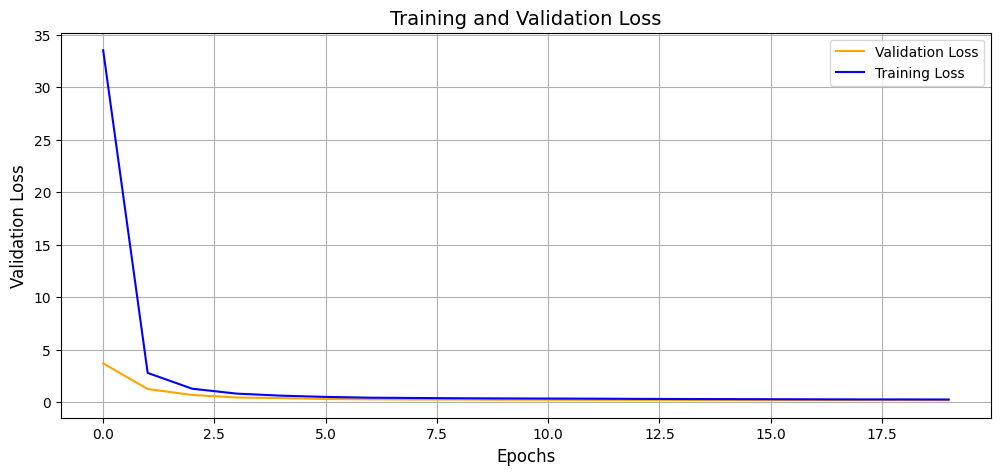

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.title("Training and Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.grid(True)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


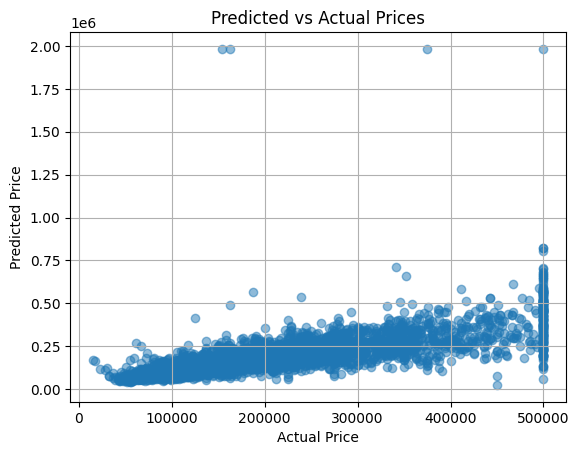

In [29]:
y_pred_log = model.predict(x_test_prepared)
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=14.5)
y_pred = np.expm1(y_pred_log)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.grid(True)

In [35]:
import numpy as np

errors = np.abs(y_pred.flatten() - y_test.values.flatten())
worst_idx = errors.argsort()[::-1][:10]  # top 10 worst

for i in worst_idx:
    actual = y_test.values.flatten()[i]
    pred = y_pred.flatten()[i]
    err = errors[i]
    print(f"Actual: {actual:,.0f} | Predicted: {pred:,.0f} | Error: {err:,.0f}")

Actual: 154,600 | Predicted: 1,982,758 | Error: 1,828,158
Actual: 162,500 | Predicted: 1,982,758 | Error: 1,820,258
Actual: 375,000 | Predicted: 1,982,758 | Error: 1,607,758
Actual: 500,001 | Predicted: 1,982,758 | Error: 1,482,757
Actual: 500,001 | Predicted: 56,623 | Error: 443,378
Actual: 450,000 | Predicted: 24,524 | Error: 425,476
Actual: 500,001 | Predicted: 114,713 | Error: 385,288
Actual: 187,500 | Predicted: 566,860 | Error: 379,360
Actual: 450,000 | Predicted: 75,387 | Error: 374,613
Actual: 341,700 | Predicted: 713,220 | Error: 371,520
